## Init

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/mount', force_remount=True)
    %cd mount/MyDrive/MachineLearningProjects/ShapeCorrection/notebooks
except ModuleNotFoundError: ...

In [2]:
import os, sys
sys.path.append("..")

In [3]:
import keras
from keras.layers import *
import tensorflow as tf
%load_ext tensorboard

import numpy as np
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt

import utils

2023-04-28 02:58:44.403492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 02:58:44.649257: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 02:58:44.676723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 02:58:44.676756: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Configuration

In [4]:
BASEDIR = Path().absolute().parent
DESTDIR = BASEDIR / "data"
MODLDIR = BASEDIR / "models"
DATASET = DESTDIR / "words.npz"

In [5]:
image_width = 128
image_height = 32
epochs = 1  # Should be at least 50
padding_token = 99
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
characters = [
	'!', '"', '#', '&', "'", '(', ')', '*', '+', ',',
	'-', '.', '/', '0', '1', '2', '3', '4', '5', '6',
	'7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D',
	'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
	'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
	'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
	'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
	's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]

## Helpers

In [6]:
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)
num_to_label = lambda t: tf.strings.join(num_to_char(t)).numpy().decode().replace("[UNK]", "")

2023-04-28 02:58:47.879610: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-28 02:58:47.879631: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-28 02:58:47.879648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-04-28 02:58:47.879895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [7]:
%%time
X, Y = np.load(DATASET).values()
maxlen = len(max(Y, key=len))
X = X.reshape([-1, image_height, image_width, 1])
Y = char_to_num(tf.strings.unicode_split(Y, input_encoding="UTF-8"))
Y = Y.to_tensor(default_value=padding_token, shape=(None, maxlen))

CPU times: user 2.99 s, sys: 6.91 s, total: 9.9 s
Wall time: 10.1 s


In [8]:
X_test, Y_test	 = X[:1000], Y[:1000]
X_val, Y_val	 = X[1000:2000], Y[1000:2000]
X_train, Y_train = X[2000:], Y[2000:]

In [9]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_height, image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Permute([2, 1, 3])(input_img)
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()

In [10]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :maxlen]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        predictions = self.prediction_model.predict(X_val)
        edit_distances.append(calculate_edit_distance(Y_val, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [11]:
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32).map(lambda a, b: {"image": a, "label": b})

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    {"image": X_train, "label": Y_train},
    validation_data={"image": X_train, "label": Y_train},
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


32/32 [==============================] - 2s 22ms/step
Mean edit distance for epoch 1: 19.8420
2952/2952 [==============================] - 274s 91ms/step - loss: 11.3022 - val_loss: 7.6740


1/1 [==============================] - 0s 32ms/step


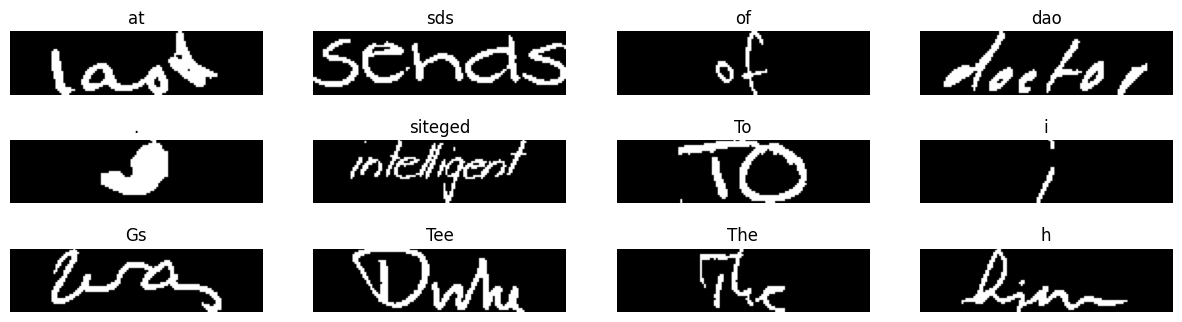

In [14]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :maxlen]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

preds = prediction_model.predict(X_val[:12])
pred_texts = decode_batch_predictions(preds)
_, subs = plt.subplots(3, 4, figsize=(15, 4))
for img, label, sb in zip(X_val[:12], pred_texts[:12], subs.ravel()):
    sb.imshow(img, cmap="gray")
    sb.set_title(label)
    sb.axis("off")


In [ ]:
meta = {
    "epochs": epochs,
    "characters": "".join(characters),
    "padding": padding_token,
    "maxlen": maxlen
}

In [15]:
utils.save(prediction_model, MODLDIR / "new.h5", metadata=meta)